### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

### Load the dataset

In [2]:
df = pd.read_csv('AirPassengers.csv')

In [3]:
# first 3 rows
df.head(3)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [4]:
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

In [5]:
# datatype of each feature
df.dtypes

Month         object
Passengers     int64
dtype: object

In [6]:
# changing the datatype of feature 'month' to datetime
df['Month'] = pd.to_datetime(df['Month'])

In [7]:
df.head(2)

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118


In [8]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [9]:
# Setting the month feature as a index
df.set_index('Month', inplace=True)

In [10]:
df.head(3)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


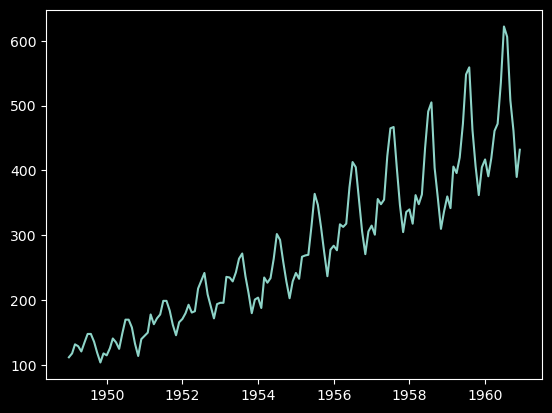

In [11]:
plt.plot(df['Passengers'])
plt.show()

### Is the data stationary?

In [12]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  0.9918802434376411  if above 0.05, data is not stationary


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'],  
                            model ='additive')

In [14]:
trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

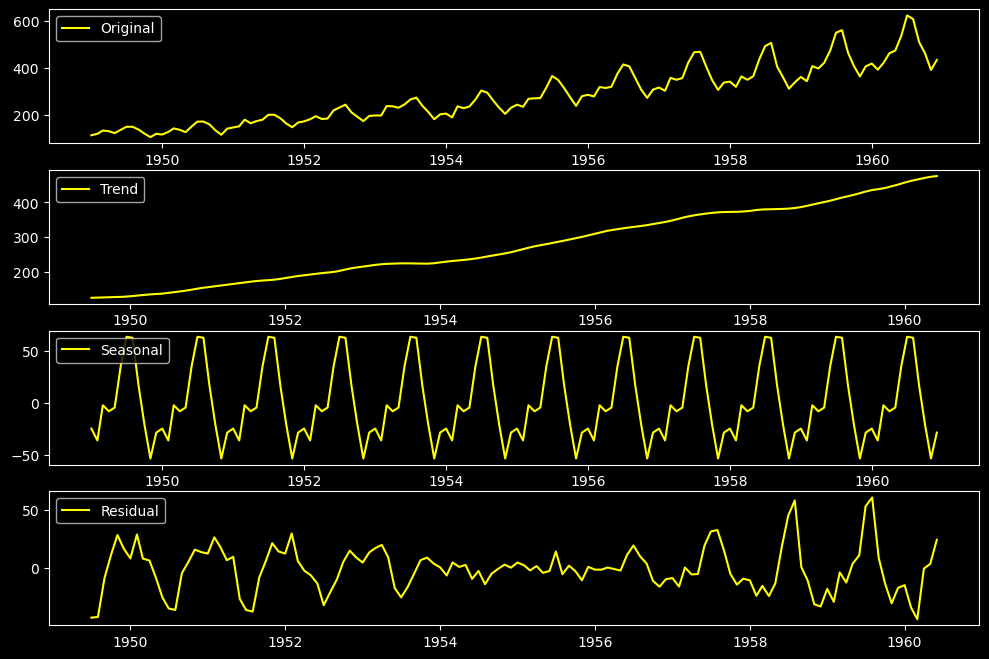

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

### Time Series Model

- We can go through the exercise of making the data stationary and performing ARIMA
- Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
- Auto arima suggests best model and parameters based on 
- AIC metric (relative quality of statistical models)

In [16]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.36 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.46 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=6.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.46 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.74 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [17]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Thu, 25 Apr 2024   AIC                           1019.178
Time:                                     23:02:28   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

### Split the data into train and test

In [18]:
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

In [20]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12))

result = model.fit() 

C:\Users\Bhuvanesh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Bhuvanesh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Thu, 25 Apr 2024   AIC                            610.538
Time:                                    23:06:20   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.369
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3204      0.102     -3.152      0.002      -0.520      -0.121
ar.S.L12       0.6844      0.642      1.066      0.286      -0.574       1.943
ar.S.L24       0.3143      0.130      2.424      0.015       0.060       0.568
ma.S.L12      -0.9802      5.507     -0.178      0.859     -11.774       9.813
sigma2        78.6353    382.722      0.205      0.837    -671.486     828.757
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index)

In [23]:
#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') 

<Axes: xlabel='Month'>

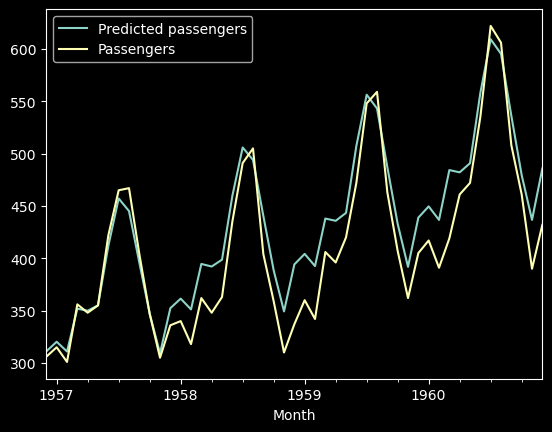

In [24]:
# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True)

In [25]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.14 RMSE
Test Score: 29.52 RMSE


In [26]:
from sklearn.metrics import r2_score
score = r2_score(X_test, prediction)
print("R2 score is: ", score)

R2 score is:  0.8581433417723958


### Forecast.. 
- You can re-train on the entire dataset before forecasting
- For now let us use the trained model
- Forecast for the next 3 years 

C:\Users\Bhuvanesh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


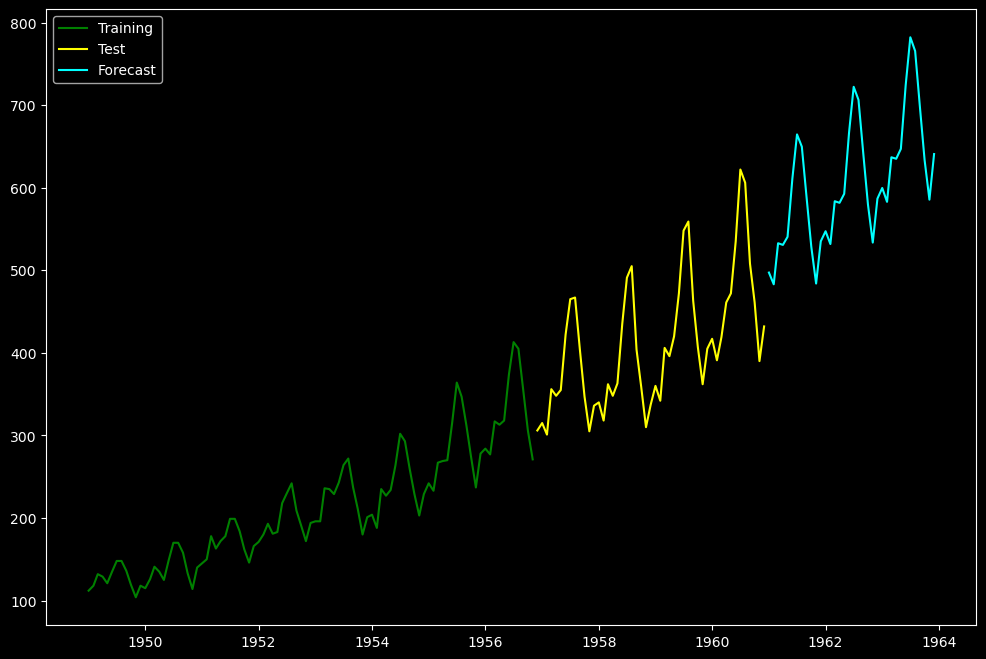

In [28]:
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()